# Region Growing (Own Implementation)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 
from skimage.color import rgb2lab

In [2]:
seedPoints = []

PARAMETERS = (
    ("EUCLIDEAN", 7.5),
    ("MANHATTAN", 25)
)
PICK = 0

##### User Input

Asks the user for input to get the seeds.

The user must click on the objects it wants the algorithm to detect (can be more than one)

<u><b>NOTE!!</b></u> The more seeds are provided, the more accurate the result will be.

In [3]:
IMG = cv2.imread("testImg1.jpg")

In [4]:
# Mouse callback functionw
def getCoords(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        seedPoints.append((x, y))
        print(f"Seed set at: ({x}, {y})")

        cv2.circle(seededImage, (x, y), 5, (0, 0, 255), -1)
        cv2.imshow("InputImage", seededImage)

# Load and display the image
seededImage = IMG.copy()
cv2.imshow("InputImage", seededImage)
cv2.setMouseCallback("InputImage", getCoords)

# Wait until any key is pressed to close the window
cv2.waitKey(0)
cv2.destroyAllWindows()

Seed set at: (380, 140)
Seed set at: (380, 140)
Seed set at: (387, 89)
Seed set at: (374, 99)
Seed set at: (395, 93)
Seed set at: (398, 81)
Seed set at: (412, 86)
Seed set at: (409, 98)
Seed set at: (425, 87)
Seed set at: (428, 112)
Seed set at: (425, 99)
Seed set at: (412, 116)
Seed set at: (417, 133)
Seed set at: (430, 129)
Seed set at: (405, 152)
Seed set at: (389, 152)
Seed set at: (395, 138)
Seed set at: (366, 131)
Seed set at: (447, 123)
Seed set at: (466, 121)
Seed set at: (484, 121)
Seed set at: (501, 122)
Seed set at: (515, 119)
Seed set at: (534, 117)
Seed set at: (554, 127)
Seed set at: (565, 140)
Seed set at: (576, 152)
Seed set at: (594, 155)
Seed set at: (605, 149)
Seed set at: (622, 148)
Seed set at: (612, 162)
Seed set at: (579, 140)
Seed set at: (571, 122)
Seed set at: (568, 106)
Seed set at: (579, 98)
Seed set at: (587, 89)
Seed set at: (601, 85)
Seed set at: (615, 92)
Seed set at: (626, 105)
Seed set at: (604, 101)
Seed set at: (590, 104)
Seed set at: (593, 124)
Seed

Get the RGB versions of both seeded and unseeded images

In [5]:
image = cv2.cvtColor(IMG, cv2.COLOR_BGR2RGB)
seededImage = cv2.cvtColor(seededImage, cv2.COLOR_BGR2RGB)

##### Region Growing Algorithm

In [6]:
objectImage = np.zeros_like(image)

In [7]:
for seed in seedPoints:
    current = image[seed[1], seed[0]]
    
    # Queue to explore the neighbor pixels
    toExploreQueue = [(seed[1], seed[0])]
    
    while len(toExploreQueue) > 0:
        # Get the next pixel from the queue
        y, x = toExploreQueue.pop(0)
        
        # This is just to avoid entering infinite loops by revisiting repeated pixels
        if objectImage[y, x].any() > 0:
            continue
        
        objectImage[y, x] = current
        
        # Get the neighbors of the current point (using 8-connectivity)
        # NOTE TO SELF!!!! Numpy keeps the image's shape inverted (width, height, RGB) is instead (height, width, RGB)
        neighbors = [
            (y-1, x),
            (y+1, x),
            (y, x-1),
            (y, x+1),
            (y-1, x-1),
            (y+1, x-1),
            (y+1, x+1),
            (y-1, x+1),
        ]
        
        for ny, nx in neighbors:
            # Checks if the neighbor is a valid pixel (doesn't exceeds the image size)
            if (0 <= ny and ny < image.shape[0]) and (0 <= nx and nx < image.shape[1]):
                # Adds more neighbors to the queue depending if the Euclidean distance is within the threshold T
                if PARAMETERS[PICK][0] == "EUCLIDEAN":
                    if ((current[0] - image[ny, nx][0])**2 + (current[1] - image[ny, nx][1])**2 + (current[2] - image[ny, nx][2])**2)**0.5 <= PARAMETERS[PICK][1]:
                        toExploreQueue.append((ny, nx))
                # Adds more neighbors to the queue depending if the Euclidean distance is within the threshold T
                elif PARAMETERS[PICK][0] == "MANHATTAN":
                    if abs(current[0] - image[ny, nx][0]) + abs(current[1] - image[ny, nx][1]) + abs(current[2] - image[ny, nx][2]) <= PARAMETERS[PICK][1]:
                        toExploreQueue.append((ny, nx))

/var/folders/3s/s_cfgxk120b8xn2g6y1m9psw0000gn/T/ipykernel_14710/3630489559.py:35: RuntimeWarning: overflow encountered in scalar subtract
  if ((current[0] - image[ny, nx][0])**2 + (current[1] - image[ny, nx][1])**2 + (current[2] - image[ny, nx][2])**2)**0.5 <= PARAMETERS[PICK][1]:


##### Results

Display the original and resulting images

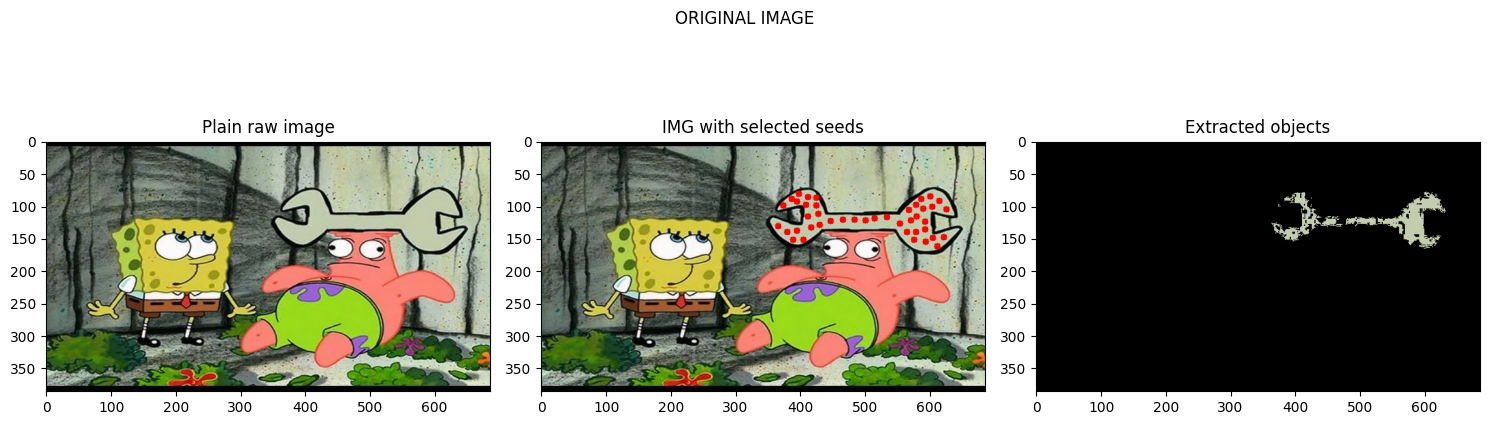

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("ORIGINAL IMAGE")

ax[0].imshow(image)
ax[0].set_title("Plain raw image")

ax[1].imshow(seededImage)
ax[1].set_title("IMG with selected seeds")

ax[2].imshow(objectImage)
ax[2].set_title("Extracted objects")

plt.tight_layout()
plt.show()

In [9]:
# Save image for future activities
cv2.imwrite('regionGrowing.png', objectImage)

True